# Forecasting future price trends by projecting historical price patterns

In our previous newsletter focusing on VectorBT PRO (VBT), we dived into the pattern detection capabilities of this powerful library. An additional key functionality is VBT's capacity to extrapolate identified price segments into the future and aggregate them for statistical analysis. This feature can be an invaluable tool for real-time decision-making in market analysis.

## Imports and set up

Given the self-contained design of VBT, a single import suffices.

In [1]:
import vectorbtpro as vbt

vbt.settings.set_theme("dark")

Configure the settings to set global defaults for Plotly figures.

In [2]:
vbt.settings.plotting.layout["width"] = 900
vbt.settings.plotting.layout["height"] = 450
vbt.settings.plotting.layout["images"] = [dict(
    source="https://vectorbt.pro/assets/logo/logo.svg",
    xref="paper", yref="paper",
    x=0, y=0.95,
    sizex=0.15, sizey=0.15,
    xanchor="center", yanchor="bottom"
)]

Let's define a set of variables for our analysis.

In [13]:
SYMBOL = "BTCUSDT"
TIMEFRAME = "1 hour"
START = "one year ago"

LAST_N_BARS = 24
PRED_N_BARS = 12

GIF_FNAME = "projections.gif"
GIF_N_BARS = 72
GIF_FPS = 4
GIF_PAD = 0.01

We will execute the analysis using price data retrieved from BinanceData, based on the parameters we previously defined.

In [4]:
data = vbt.BinanceData.pull(SYMBOL, timeframe=TIMEFRAME, start=START)

0it [00:00, ?it/s]

## Find and plot projections

Let's write a function that analyzes the most recent price trend and employs it as a pattern to identify similar price movements in historical data. This pattern recognition function will focus exclusively on segments of price history having a comparable percentage change from their respective starting points.

In [5]:
def find_patterns(data):
    price = data.hlc3
    pattern = price.values[-LAST_N_BARS:]
    pattern_ranges = price.vbt.find_pattern(
        pattern=pattern,
        rescale_mode="rebase",
        overlap_mode="allow",
        wrapper_kwargs=dict(freq=TIMEFRAME)
    )
    pattern_ranges = pattern_ranges.status_closed
    return pattern_ranges

pattern_ranges = find_patterns(data)
print(pattern_ranges.count())

31


We have identified a number of price segments that closely resemble the latest price trend. Now, we'll write a function that extracts the price data immediately succeeding each identified segment and plots these as extensions of the price trend. These subsequent segments are known as "projections."

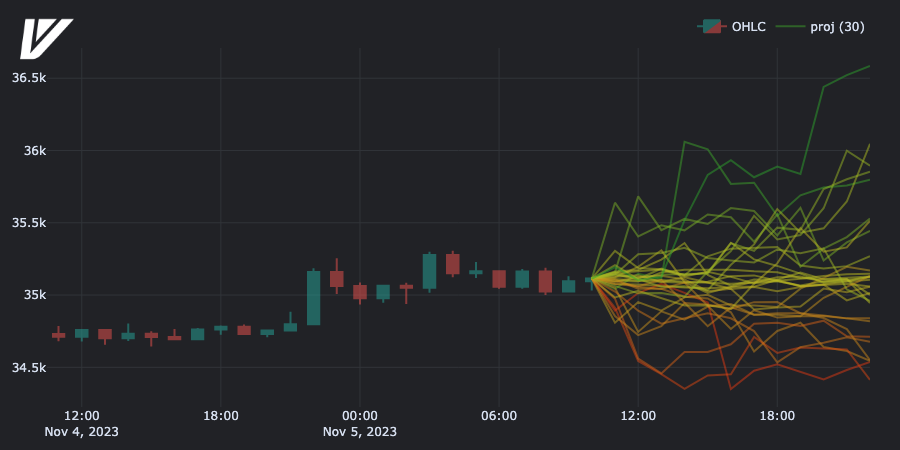

In [6]:
def plot_projections(data, pattern_ranges, **kwargs):
    projection_ranges = pattern_ranges.with_delta(
        PRED_N_BARS,
        open=data.open,
        high=data.high,
        low=data.low,
        close=data.close,
    )
    projection_ranges = projection_ranges.status_closed
    return projection_ranges.plot_projections(
        plot_past_period=LAST_N_BARS, 
        **kwargs,
    )

plot_projections(data, pattern_ranges, plot_bands=False).show_png()

As we can see, similar price movements have historically branched into a diverse set of trajectories. For a visually compelling and statistically robust forecast, we will display the confidence bands encompassing all the projections, with 60% of these projections falling between the upper and lower bands.

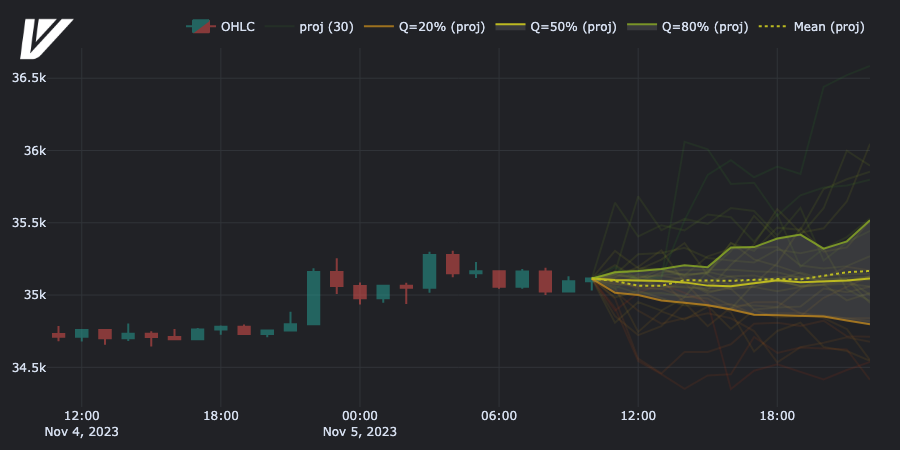

In [7]:
plot_projections(data, pattern_ranges, plot_bands=True).show_png()

## Generate animation

Lastly, we will compile a GIF animation that iterates through a specified range of bars, applying the aforementioned procedure to each bar within that range.

In [14]:
def plot_frame(frame_index, **kwargs):
    sub_data = data.loc[:frame_index[-1]]
    pattern_ranges = find_patterns(sub_data)
    if pattern_ranges.count() < 3:
        return None
    return plot_projections(sub_data, pattern_ranges, **kwargs)

vbt.save_animation(
    GIF_FNAME,
    data.index[-GIF_N_BARS:],
    plot_frame,
    plot_projections=False,
    delta=1,
    fps=GIF_FPS,
    writer_kwargs=dict(loop=0),
    yaxis_range=[
        data.low.iloc[-GIF_N_BARS:].min() * (1 - GIF_PAD), 
        data.high.iloc[-GIF_N_BARS:].max() * (1 + GIF_PAD)
    ],
)

  0%|          | 0/72 [00:00<?, ?it/s]

Bear in mind that while the confidence bands describe past performance, they should not be used as guarantees of future results.